#9 - Notebook that implements a Random Forest using TF-IDF and Supplemental Dataset



---

### **This notebook primarily contains code that implements a Random Forest model using TF-IDF (an NLP technique), the original & supplemental dataset.**
---
This model will integrate stories from the Guardian dataset with the original dataset and retrain the model. The true stories will be split 50/50 between the original true stories and stories from the Guardian set. The total number of true stories will be equal to the fake ones to avoid class imbalance.

---
# Importing libraries and defining constants

In [1]:
# Imports library necessary for mounting Google Drive.
from google.colab import drive
# Mounts Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copies the model helper function python program from Google Drive to Colab Storage for use in this notebook.
!cp "drive/MyDrive/Fake News Classifier/Helper Functions/model_helperfunctions.py" .

In [3]:
# Imports all the libraries required for the notebook to run.
import pandas as pd
import numpy as np
import model_helperfunctions
import ast
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [4]:
# Sets the path for the data directory and the filenames.
DATA_PATH = "/content/drive/MyDrive/Data/"
PRE_PROCESSED_DATA_FILE_NAME = 'kaggle_newsdataset_preprocessed.csv'
GUARDIAN_DATA_FILE_NAME = 'guardian_newsdataset_cleaned.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [5]:
# Sets the path to save the models as well as the filenames.
SAVE_MODEL = True
MODEL_PATH = "/content/drive/MyDrive/Models/"
MODEL_FILE_NAME = 'rf_tf-idf_plusguardian_model.sav'

# Load the data

In [6]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [7]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [8]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


In [9]:
df_guard = pd.read_csv(DATA_PATH + GUARDIAN_DATA_FILE_NAME, 
                 low_memory = False)

In [10]:
df_guard.tt_tokens = df_guard.tt_tokens.map(ast.literal_eval)

# Integrate the guardian stories as true news

## split original data by label

In [11]:
df_fake = df[df.label == 'fake']

In [12]:
df_true_og = df[df.label == 'true']

In [13]:
len(df_fake)/2

8723.5

## Take random sample of original true data

This is equal to half of fake data so as to keep the classes balanced.

In [14]:
df_true_og_sample = df_true_og.sample(8724, random_state = RANDOM_STATE)

## Take random sample of guardian data

In [15]:
df_guard_sample = df_guard.sample(8723, random_state = RANDOM_STATE)

### Assign the label true

In [16]:
df_guard_sample['label'] = 'true'

## Combine datasets

In [17]:
df_true_og_sample['tt_tokens'] = df_true_og_sample['clean_title_tokens'] + df_true_og_sample['clean_text_tokens']

In [18]:
df_fake['tt_tokens'] = df_fake['clean_title_tokens'] + df_fake['clean_text_tokens']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_all = pd.concat([df_fake[['label', 'tt_tokens']], 
                         df_true_og_sample[['label', 'tt_tokens']], 
                        df_guard_sample[['label', 'tt_tokens']]], axis=0)

# Split the data

In [20]:
y = df_all.label
X = df_all.drop('label', axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [22]:
X_train.shape

(27915, 1)

In [23]:
X_test.shape

(6979, 1)

# Encode the labels

In [24]:
le = LabelEncoder()

In [25]:
y_train_enc = le.fit_transform(y_train)

In [26]:
y_test_enc = le.transform(y_test)

# Train the models

In [27]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    
    # Train and evaluate a bag of words representation with a random forest classifier.
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helperfunctions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helperfunctions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

## title & text only - lowercase, only stopwords but a larger set.

In [28]:
# Using the expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

Remove 'via' from the list of stopwords because it is particular to this dataset.

In [29]:
expanded_stopwords.remove('via')

Remove UK specific terms that affects the model.

In [30]:
expanded_stopwords.remove('eu')
expanded_stopwords.remove('uk')

In [31]:
def lowercase_and_only_expanded_stopwords(doc):
    # Remove stopwords and lowercase tokens.
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.93      0.96      0.94     13957
        true       0.96      0.92      0.94     13958

    accuracy                           0.94     27915
   macro avg       0.94      0.94      0.94     27915
weighted avg       0.94      0.94      0.94     27915



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


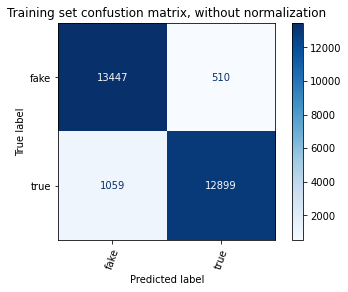

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


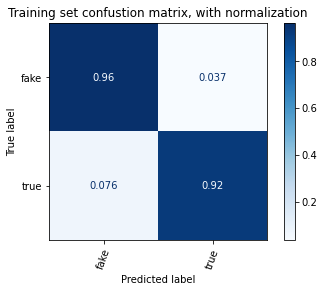

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.88      0.91      0.90      3490
        true       0.91      0.88      0.89      3489

    accuracy                           0.89      6979
   macro avg       0.89      0.89      0.89      6979
weighted avg       0.89      0.89      0.89      6979



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


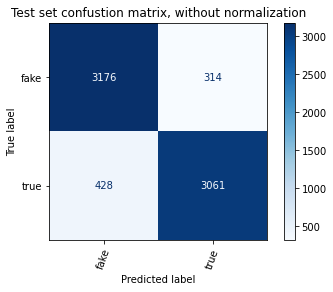

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


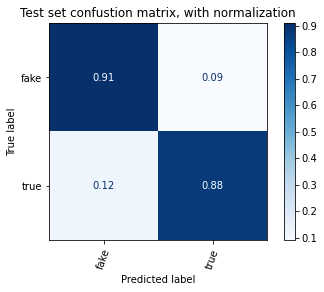

In [32]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['tt_tokens'], 
                                                        X_test['tt_tokens'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helperfunctions.passthrough,
                                                 min_samples_split = 0.005)

In [33]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,importance
said,0.136615
its,0.047859
the,0.041476
just,0.035257
on,0.030973
you,0.030457
this,0.024499
in,0.024101
like,0.021230
know,0.017967


# Save the model

In [34]:
try: 
    os.mkdir(MODEL_PATH)
    print('Directory to save the models has been created.')
except FileExistsError:
    print('Directory to save the models already exists. No new directory will be created')
    pass

Directory to save the models already exists. No new directory will be created


In [35]:
if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(MODEL_PATH + MODEL_FILE_NAME, 'wb'))

---
# **Summary**

The accuracy and f1 scores for this model are somewhat worse than the model trained on the original dataset, 0.89 here vs. 0.94, but this model should generalize better because the news stories labeled true came from more than one news source.

Not surprisingly, the list of important features changed compared to what the model found for the previous version of the dataset.